# Research on Telecome Prepaid Plans

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
Data consist of 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Analyze clients' behavior and determine which prepaid plan brings in more revenue.

Description of the plans:

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Surf 
Monthly charge: 20
500 monthly minutes, 50 texts, and 15 GB of data
After exceeding the package limits:
1 minute: 3 cents
1 text message: 3 cents
1 GB of data: 10

Ultimate 
Monthly charge: 70
3000 monthly minutes, 1000 text messages, and 30 GB of data
After exceeding the package limits:
1 minute: 1 cent
1 text message: 1 cent
1 GB of data: 7

Price($)


## Step 1. Open the data file and study the general information. 

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

### data on users

In [2]:
# users_data
megalines_users = pd.read_csv('/Users/fanibhushan/Downloads/megaline_users.csv') 
megalines_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### data on calls

In [3]:
# calls data
megalines_calls = pd.read_csv('/Users/fanibhushan/Downloads/megaline_calls.csv') 
megalines_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### data on web sessions

In [4]:
#internet data
megalines_internet = pd.read_csv('/Users/fanibhushan/Downloads/megaline_internet.csv') 
megalines_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### data on texts

In [5]:
#message data
megalines_messages = pd.read_csv('/Users/fanibhushan/Downloads/megaline_messages.csv') 
megalines_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### data on the plans

In [6]:
#plans data info
megalines_plans = pd.read_csv('/Users/fanibhushan/Downloads/megaline_plans.csv') 
megalines_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
#duration== 0
megalines_calls.loc[megalines_calls['duration']== 0,'duration'].value_counts()

0.0    26834
Name: duration, dtype: int64

In [8]:
#mb_used == 0
megalines_internet.loc[megalines_internet['mb_used']== 0,'mb_used'].value_counts()

0.0    13747
Name: mb_used, dtype: int64

### Conclusion

There are total 5 different dataset:

megalines_users: contain info about name,age,city,plan name,subscription date

megalines_calls: info about call date & duration & identifier of the user making call

megalines_internet: info about message date & identifier of the user sending text

megalines_messages: info about data spent during the session in mb, session date & user identifier

megalines_plans: info about two different plans,
                 after exceeding the limit: usd_per_minute,usd_per_message,usd_per_gb,  
                 monthly: charge in US dollar, min allowances,text allowances,data volume allowances
                 
duration column in megalines_calls dataset has 26834 rows where duration == 0
mb_used column in megalines_internet dataset has 13747 rows where mb_used == 0

In data preprocessing step we will go analyse these two.

## Step 2. Data preprocessing

In [9]:
#For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute
megalines_calls['duration'] = megalines_calls['duration'].apply(np.ceil)
megalines_calls.head(5)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0


As the company rounds seconds to minutes so: For calls, each individual call is rounded up, even if the call lasted just one second, it will be counted as one minute. Used ceil() method rounds a number UP to the nearest integer.

In [10]:
#adding a month column to all the three dataset
megalines_calls['month'] = pd.DatetimeIndex(megalines_calls['call_date']).month
megalines_internet['month'] = pd.DatetimeIndex(megalines_internet['session_date']).month
megalines_messages['month'] = pd.DatetimeIndex(megalines_messages['message_date']).month

### The number of text messages sent per month

In [11]:
#For each user number of messages sent per month
messages_pivot = megalines_messages.pivot_table(index=['user_id','month'],values='id',aggfunc='count')
messages_pivot_reset_index = messages_pivot.reset_index()
messages_pivot_reset_index.columns = ['user_id','month','message_number']
messages_pivot_reset_index.head()

,user_id,month,message_number
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


### The number of calls made and minutes used per month

In [12]:
#For each user number of calls made and minutes used per month
calls_pivot= megalines_calls.pivot_table(index=['user_id','month'], values='duration',aggfunc=['sum','count'])
calls_pivot_reset_index = calls_pivot.reset_index()
calls_pivot_reset_index.columns = ['user_id','month','call_duration','call_number']
calls_pivot_reset_index.head()

,user_id,month,call_duration,call_number
0,1000,12,124.0,16
1,1001,8,182.0,27
2,1001,9,315.0,49
3,1001,10,393.0,65
4,1001,11,426.0,64


### The volume of data per month

In [13]:
#For each user volume of data per month
internet_pivot = megalines_internet.pivot_table(index=['user_id','month'],values='mb_used',aggfunc='sum')
internet_pivot_reset_index = internet_pivot.reset_index()
internet_pivot_reset_index.head()

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


In [14]:
#convert mb_used to gb_used and if someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.
internet_pivot_reset_index['gb_used'] = (internet_pivot_reset_index['mb_used']/1024).apply(np.ceil)
internet_pivot_reset_index.head()

,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2.0
1,1001,8,6919.15,7.0
2,1001,9,13314.82,14.0
3,1001,10,22330.49,22.0
4,1001,11,18504.30,19.0


As the company rounds mb to gb so: For each user and based on their monthly usage of internet is rounded up, even if the mb_used was suppose 1901.47 mb this month, they will be charged for 2 gb. Converted mb to gb. Used ceil() method rounds a number UP to the nearest integer.

In [15]:
# For each user minutes used per month call_duration == 0
calls_pivot_reset_index.loc[calls_pivot_reset_index['call_duration']==0,'call_duration'].value_counts()

0.0    2
Name: call_duration, dtype: int64

Earlier there were 26834 rows where duration was 0 but after calculating the call_duration for each user minutes used per month call_duration == 0 has only 2 rows.
Reason for duration == 0 could be because these calls might be missed calls. 

In [16]:
# For each user volume of data per month mb_used not equal to 0
internet_pivot_reset_index.loc[internet_pivot_reset_index['mb_used']==0,'mb_used']

Series([], Name: mb_used, dtype: float64)

Earlier there were 13747 rows where mb_used was 0 but after calculating for each user volume of data per month there is no users whose mb_used is 0.

In [17]:
#extracting plan & user_id from megaline_users dataframe
megalines_users_new= megalines_users[['user_id', 'plan','city']] 
megalines_users_new.tail()

,user_id,plan,city
495,1495,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,1496,surf,"New Orleans-Metairie, LA MSA"
497,1497,ultimate,"Los Angeles-Long Beach-Anaheim, CA MSA"
498,1498,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA"
499,1499,surf,"Orlando-Kissimmee-Sanford, FL MSA"


In [18]:
#consequentially merging one dataframe with another. We use fillna() method at the end to fill missing data with 0
total1 = pd.merge(left=internet_pivot_reset_index , right=calls_pivot_reset_index, how='outer',on=['user_id','month']).fillna(0)
total2 = pd.merge(left=total1, right=messages_pivot_reset_index, how='outer',on=['user_id','month']).fillna(0)
merged_data = pd.merge(left=total2,right=megalines_users_new,how='left',on='user_id')

In [19]:
print(len(merged_data))
merged_data.head()

2293


,user_id,month,mb_used,gb_used,call_duration,call_number,message_number,plan,city
0,1000,12,1901.47,2.0,124.0,16.0,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,6919.15,7.0,182.0,27.0,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,13314.82,14.0,315.0,49.0,44.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,22330.49,22.0,393.0,65.0,53.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,18504.30,19.0,426.0,64.0,36.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"


In [20]:
#checking the datatype
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   int64  
 2   mb_used         2293 non-null   float64
 3   gb_used         2293 non-null   float64
 4   call_duration   2293 non-null   float64
 5   call_number     2293 non-null   float64
 6   message_number  2293 non-null   float64
 7   plan            2293 non-null   object 
 8   city            2293 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 179.1+ KB


In [21]:
#convert float to int type
merged_data['call_duration']= merged_data['call_duration'].astype('int64')
merged_data['call_number']= merged_data['call_number'].astype('int64')
merged_data['mb_used']= merged_data['mb_used'].astype('int64')
merged_data['gb_used']= merged_data['gb_used'].astype('int64')
merged_data['message_number']= merged_data['message_number'].astype('int64')

### The monthly revenue from each user

In [22]:
#For each user monthly revenue from each user

def cost(row):
    plan_name= row['plan']
    gb_used=row['gb_used']
    call_duration=row['call_duration']
    call_number=row['call_number']
    message_number=row['message_number']
    total_revenue = 0
    revenue_plan = 0
    revenue_from_data = 0
    revenue_from_calls = 0
    revenue_from_texts = 0
    #now let's find the rate for user using our prepaid plans. We will create new variable cost_plan.
    if plan_name=='surf':
        revenue_plan =20
        if gb_used > 15:
            revenue_from_data = ((gb_used)-15)*10
        if call_duration > 500:
            revenue_from_calls = ((call_duration-500)*3)/100
        if message_number > 50:
            revenue_from_texts = ((message_number-50)*3)/100
     
    elif plan_name=='ultimate':
        revenue_plan =70
        if gb_used > 30:
            revenue_from_data = ((gb_used)-30)*7
        if call_duration > 3000:
            revenue_from_calls = ((call_duration-3000)*1)/100
        if message_number > 1000:
            revenue_from_texts = ((message_number-1000)*1)/100
    total_revenue = revenue_plan+revenue_from_data+revenue_from_calls+revenue_from_texts
    
    return total_revenue
           
        
# now we apply our function to every row of our data.
merged_data['monthly_revenue']=merged_data.apply(cost,axis=1)
display(merged_data.head())
print(len(merged_data))

,user_id,month,mb_used,gb_used,call_duration,call_number,message_number,plan,city,monthly_revenue
0,1000,12,1901,2,124,16,11,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,6919,7,182,27,30,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,13314,14,315,49,44,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,22330,22,393,65,53,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,18504,19,426,64,36,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00


2293


In [23]:
#checking the datatype
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          2293 non-null   int64  
 1   month            2293 non-null   int64  
 2   mb_used          2293 non-null   int64  
 3   gb_used          2293 non-null   int64  
 4   call_duration    2293 non-null   int64  
 5   call_number      2293 non-null   int64  
 6   message_number   2293 non-null   int64  
 7   plan             2293 non-null   object 
 8   city             2293 non-null   object 
 9   monthly_revenue  2293 non-null   float64
dtypes: float64(1), int64(7), object(2)
memory usage: 197.1+ KB


### Conclusion

In this step:
For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute.
For web traffic,For each user and based on their monthly usage of internet is rounded up.If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Calculated some new columns such as:
call_duration & call_number: for each users number of calls made and minutes used per month
message_number: for each users number of text messages sent per month
gb_used: for each users volume of data per month
monthly_revenue: monthly revenue from each users

Converted float to int type for the following columns: call_duration,call_number,message_number,gb_used,mb_used
monthly_revenue(did not converted into int type as it is revenue from the person and value after decimal place is important, so kept it as float type)

In this step also checked for call_duration == 0. Now in call_duration column data is based on each user minutes used per month so now only two rows consist of call_duration == 0. 
Reason for duration==0: Could be users might have missed the call
This won't affect the results of our analysis because we are calculating the monthly revenue from each user & missed calls is like no calls so no contribution of that call to the monthly revenue. Also there are only two rows with call_duration ==0. So we can keep this at it is.

Earlier there were mb_used == 0 but after calculating mb_used monthly per person, it was eliminated.


## Step 3. Analyse the data

In [24]:
#summary of statistics
merged_data.describe()

,user_id,month,mb_used,gb_used,call_duration,call_number,message_number,monthly_revenue
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,9.172700,16763.904492,16.870475,429.283471,60.067597,33.166594,64.351147
std,143.051927,2.496386,7967.219116,7.796174,236.320077,32.402563,34.070085,46.624945
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1122.000000,8.000000,12235.000000,12.000000,265.000000,38.000000,3.000000,23.480000
50%,1245.000000,10.000000,16830.000000,17.000000,425.000000,60.000000,26.000000,70.000000
75%,1368.000000,11.000000,20999.000000,21.000000,572.000000,79.000000,51.000000,70.000000
max,1499.000000,12.000000,70931.000000,70.000000,1510.000000,205.000000,266.000000,590.370000


### Describe the customers' behavior

In [25]:
#average monthly usage of each user_id
merged_data_pivot = merged_data.pivot_table(index=['user_id','plan'],values=['call_duration','gb_used','message_number'],aggfunc='mean').reset_index()
merged_data_pivot


,user_id,plan,call_duration,gb_used,message_number
0,1000,ultimate,124.000000,2.000000,11.000000
1,1001,surf,345.600000,16.200000,41.400000
2,1002,surf,276.333333,13.666667,29.333333
3,1003,surf,1104.000000,27.000000,50.000000
4,1004,surf,346.500000,19.625000,22.125000
...,...,...,...,...,...
485,1495,surf,441.250000,24.750000,0.000000
486,1496,surf,291.000000,13.200000,13.000000
487,1497,ultimate,300.000000,11.000000,50.000000
488,1498,surf,291.909091,20.727273,0.000000


### Find the minutes, texts, and volume of data the users of surf data require per month

In [26]:
#surf_data
merged_data_surf= merged_data.loc[merged_data['plan']=='surf']
merged_data_pivot_surf = merged_data_surf.pivot_table(index=['user_id','plan'],values=['call_duration','gb_used','message_number']).reset_index()
merged_data_pivot_surf

,user_id,plan,call_duration,gb_used,message_number
0,1001,surf,345.600000,16.200000,41.400000
1,1002,surf,276.333333,13.666667,29.333333
2,1003,surf,1104.000000,27.000000,50.000000
3,1004,surf,346.500000,19.625000,22.125000
4,1005,surf,496.000000,17.000000,11.000000
...,...,...,...,...,...
328,1494,surf,473.500000,15.333333,29.000000
329,1495,surf,441.250000,24.750000,0.000000
330,1496,surf,291.000000,13.200000,13.000000
331,1498,surf,291.909091,20.727273,0.000000


### Find the minutes, texts, and volume of data the users of ultimate data require per month

In [27]:
#ultimate data
merged_data_ultimate= merged_data.loc[merged_data['plan']=='ultimate']
merged_data_pivot_ultimate = merged_data_ultimate.pivot_table(index=['user_id','plan'],values=['call_duration','gb_used','message_number']).reset_index()
merged_data_pivot_ultimate

,user_id,plan,call_duration,gb_used,message_number
0,1000,ultimate,124.000000,2.000000,11.000000
1,1006,ultimate,34.500000,17.500000,77.000000
2,1008,ultimate,518.666667,18.666667,28.000000
3,1011,ultimate,415.285714,18.857143,53.000000
4,1013,ultimate,219.000000,20.000000,16.000000
...,...,...,...,...,...
152,1482,ultimate,280.333333,7.000000,31.333333
153,1487,ultimate,416.000000,14.000000,66.000000
154,1490,ultimate,373.000000,31.833333,0.000000
155,1493,ultimate,465.000000,15.200000,0.000000


### Calculate the mean, dispersion, and standard deviation of each plan

In [28]:
#Calculate mean & standard deviation for surf
print('surf_mean:',merged_data_pivot_surf.mean())
print('surf_sd: ',np.std(merged_data_pivot_surf))

surf_mean: user_id           1245.306306
call_duration      408.737038
gb_used             15.996965
message_number      32.408931
dtype: float64
surf_sd:  user_id           141.431641
call_duration     199.069580
gb_used             6.093745
message_number     30.971169
dtype: float64


In [29]:
#Calculate mean & standard deviation for ultimate
print('ultimate_mean:',merged_data_pivot_ultimate.mean())
print('ultimate_sd: ',np.std(merged_data_pivot_ultimate))

ultimate_mean: user_id           1256.573248
call_duration      407.959877
gb_used             16.154847
message_number      38.471532
dtype: float64
ultimate_sd:  user_id           150.253891
call_duration     199.718024
gb_used             5.763927
message_number     32.822243
dtype: float64


#### Conclusion

Plans: Surf & Ultimate

Means of plans:
Surf- Means of call_duration= 409, Mean of gb_used= 16, Mean of msg_num= 32
Ultimate- Means of call_duration= 408, Mean of gb_used= 16, Mean of msg_num= 38

Standard deviation of plans:
Surf- Std of call_duration= 199, Std of gb_used= 6, Std of msg_num= 31
Ultimate- Std of call_duration= 200, Std of gb_used= 6, Std of msg_num= 33

In order to get an idea about how our distribution looks like we get this information from mean & standard devitaion.
Call_duration & gb_used: For both the plan surf & ultimate is almost same  
msg_mum: Average message number for ultimate is high as compared to surf but message number for surf is more consistent as compared to ultimate.

### Histogram plot & distribution

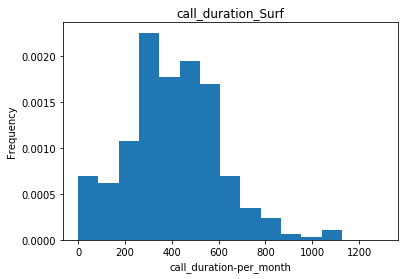

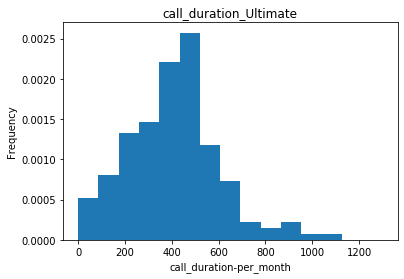

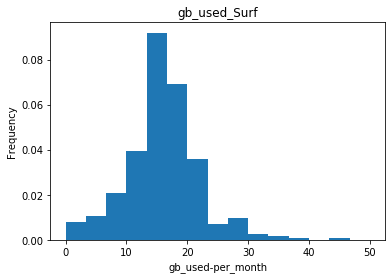

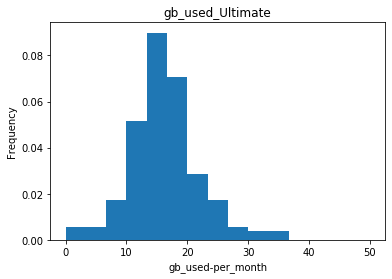

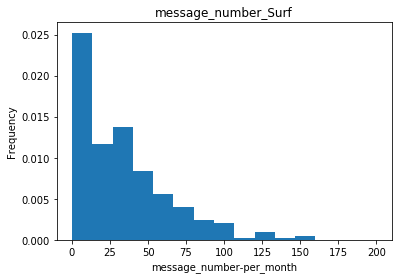

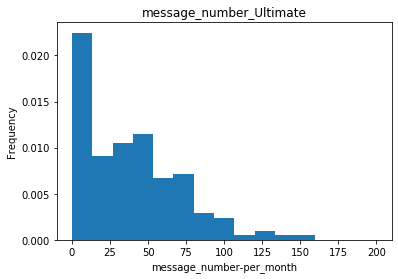

In [30]:
#histogram for call_duration, gb_used, message_number for both the palns
data_new = [{"column":"call_duration","bin":15,"range":1300},{"column":"gb_used","bin":15,"range":50},{"column":"message_number","bin":15,"range":200}]

for x in data_new:
    merged_data_pivot_surf.hist(x["column"],bins=x["bin"], range=(0,x["range"]),grid=False,density=True)
    plt.title(x["column"]+"_"+"Surf")
    plt.xlabel(x["column"]+"-"+"per_month")
    plt.ylabel('Frequency')
    merged_data_pivot_ultimate.hist(x["column"],bins=x["bin"], range=(0,x["range"]),grid=False,density=True)
    plt.title(x["column"]+"_"+"Ultimate")
    plt.xlabel(x["column"]+"-"+"per_month")
    plt.ylabel('Frequency')

#### Conclusion

Plan: Surf & Ultimate
describe the distribution: shape,centre,spread,outliers

We would prefer our data to be symmetric that means: mean=median or very close to each other.

shape:symmetric,left or right skewed, unimodal(one peak) or bimodal
Call_duration: The histogram above is skewed that means longer tailed on one end.Histogram is right tailed, we call it right skewed.As the distribution is right skewed that signifies mean > median.
gb_used:Histogram is normally distributed. Signifies mean=mdeian
message_number:The histogram above is skewed that means longer tailed on one end.Histogram is right tailed, we call it right skewed.As the distribution is right skewed that signifies mean > median.


Centre: Mode,Mean,Median
Mean & Median for gb_used is same but for call_duration & message number mean > median.
Mode: Ideally we would like to have one maximum frequency that is mode & when we have one mode we call this as unimodal. All the previous histogram has been unimodal. Except call_duration_surf, where we have two mode so it is bimodal distribution.

Mean:
Average "msg_num" for ultimate is better than surf.
Average "call_duration" for surf is better than ultimate.
Average "gb_used" is same for both plans.

Spread: (range=max-min),sd
Standard_deviation: Consistency for surf is better.
"call_duration" & "msg_num" for surf is more consistent as compared to ultimate as standard deviation for surf is lower than ultimate.
Consistency of gb_used for both the plans are same.

Range: Min & Max(i.e max-min= spread) of the minutes, texts, and volume of data the users of each plan require per month
Surf: {call_duration=(0,850)},{gb_used(3,29)},{msg_num(0,110)}
Ultimate: {call_duration=(0,790)},{gb_used=(5,29)},{msg_num(0,130)}

Outliers: Extreme values that show in our data from time to time.
Reason for outliers: either incorrect value or why this value is so special. 
Outlier in histogram: if there is significant gap in between the bins of histogram, that could be outliers.
If we have fairly significant gap not just the little space then the gap looks like an outlier.Here the gap is significant and also this is verified by the boxplot and there is outliers.
Exist outliers:
surf: (call_duration > 830),(3 < gb_used > 29),(msg_num > 120)
ultimate: (call_duration > 830),(3 < gb_used > 29),(msg_num > 140)

## Step 4. Test the hypothesis

In [31]:
#print merged data
merged_data

,user_id,month,mb_used,gb_used,call_duration,call_number,message_number,plan,city,monthly_revenue
0,1000,12,1901,2,124,16,11,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,6919,7,182,27,30,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,13314,14,315,49,44,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,22330,22,393,65,53,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,18504,19,426,64,36,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00
...,...,...,...,...,...,...,...,...,...,...
2288,1470,11,0,0,632,81,156,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",27.14
2289,1470,12,0,0,592,78,153,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",25.85
2290,1484,11,0,0,38,2,1,surf,"Dallas-Fort Worth-Arlington, TX MSA",20.00
2291,1491,4,0,0,44,8,6,surf,"Grand Rapids-Kentwood, MI MSA",20.00


In [32]:
#unique name of the city
merged_data['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [33]:
#create a new city_type with users of NY-NJ area & users from other regions.
city = merged_data['city']

def get_city(city):
    if 'New York-Newark-Jersey City, NY-NJ-PA MSA' in city:
        return 'NY-NJ'
    return 'others'
        
merged_data['city_type'] = merged_data['city'].apply(get_city)
merged_data.head(5)

,user_id,month,mb_used,gb_used,call_duration,call_number,message_number,plan,city,monthly_revenue,city_type
0,1000,12,1901,2,124,16,11,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00,others
1,1001,8,6919,7,182,27,30,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00,others
2,1001,9,13314,14,315,49,44,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00,others
3,1001,10,22330,22,393,65,53,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09,others
4,1001,11,18504,19,426,64,36,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00,others


### The average revenue from users of Ultimate and Surf calling plans differs

In [34]:
#average revenue of surf & ultimate
merged_data_revenue_pivot= merged_data.pivot_table(index=['user_id','plan'],values='monthly_revenue',aggfunc='mean').reset_index()
merged_data_revenue_pivot

,user_id,plan,monthly_revenue
0,1000,ultimate,70.000000
1,1001,surf,50.018000
2,1002,surf,33.333333
3,1003,surf,158.120000
4,1004,surf,76.250000
...,...,...,...
485,1495,surf,118.325000
486,1496,surf,28.000000
487,1497,ultimate,70.000000
488,1498,surf,77.272727


In [35]:
#mean of surf & ultimate
merged_data_revenue_pivot.groupby(['plan']).mean()

,user_id,monthly_revenue
plan,,
surf,1245.306306,58.194344
ultimate,1256.573248,71.823284


From the average monthly revenue of surf & ultimate. The difference between these average is significant. Instead of basing your comparison on the averages alone, we use the data sets to perform a statistical test

In [36]:
#surf monthly revenue
surf= merged_data_revenue_pivot.loc[merged_data_revenue_pivot['plan']=='surf']
surf.head(2)
surf_revenue = surf[['monthly_revenue']]
surf_revenue.head()

,monthly_revenue
1,50.018000
2,33.333333
3,158.120000
4,76.250000
5,40.000000


In [37]:
#ultimate monthly revenue
ultimate= merged_data_revenue_pivot.loc[merged_data_revenue_pivot['plan']=='ultimate']
ultimate.head(2)
ultimate_revenue = ultimate[['monthly_revenue']]
ultimate_revenue.head()

,monthly_revenue
0,70.0
6,77.0
8,70.0
11,70.0
13,70.0


In [38]:
#test hypothesis
alpha = 0.05 

results = st.ttest_ind(surf_revenue,ultimate_revenue)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

p-value: [0.00011355]
We reject the null hypothesis


#### Conclusion

Our analysis suggest that users behaviour differ from surf to ultimate, but we don't have enough data to say precisely how. May be users of surf have an average call_duration better than ultimate or average msg_num for ultimate is better than surf.
Reject: The average revenue from users of Ultimate and Surf calling plans are same.
High chance of statistically different (but we can NEVER conclude that it is different)

### The average revenue from users in NY-NJ area is different from that of the users from other regions.

In [39]:
#average revenue from users in NY-NJ area & users from other regions.
merged_data_city_pivot= merged_data.pivot_table(index=['user_id','city_type'],values='monthly_revenue',aggfunc='mean').reset_index()
merged_data_city_pivot

,user_id,city_type,monthly_revenue
0,1000,others,70.000000
1,1001,others,50.018000
2,1002,others,33.333333
3,1003,others,158.120000
4,1004,others,76.250000
...,...,...,...
485,1495,NY-NJ,118.325000
486,1496,others,28.000000
487,1497,others,70.000000
488,1498,NY-NJ,77.272727


In [40]:
#mean of users in NY-NJ area & users from other regions.
merged_data_city_pivot.groupby(['city_type']).mean()

,user_id,monthly_revenue
city_type,,
NY-NJ,1225.392405,59.889672
others,1253.437956,63.074667


In [41]:
#average revenue of users in NY-NJ area 
NY_NJ= merged_data_city_pivot.loc[merged_data_city_pivot['city_type']=='NY-NJ']
NY_NJ.head(2)
NY_NJ_revenue = NY_NJ[['monthly_revenue']]
NY_NJ_revenue.head()

,monthly_revenue
14,29.420000
22,56.125000
24,21.920000
26,33.333333
30,70.000000


In [42]:
#average revenue of users from other regions.
others= merged_data_city_pivot.loc[merged_data_city_pivot['city_type']=='others']
others.head(2)
others_revenue = others[['monthly_revenue']]
others_revenue.head(5)

,monthly_revenue
0,70.000000
1,50.018000
2,33.333333
3,158.120000
4,76.250000


In [43]:
#test hypothesis
alpha = 0.05 

results = st.ttest_ind(NY_NJ_revenue,others_revenue)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

p-value: [0.48043819]
We fail to reject the null hypothesis


#### Conclusion
This probability is clearly too high to conclude that there is a no significant difference between the average revenue from users in NY-NJ ares & other regions.
Can't reject: The average revenue from users in NY-NJ area is same from that of the users from other regions
high chance of equal (but we can NEVER conclude that it is equal)


### Conclusion

Test the hypothesis:
H0: The average revenue from users of Ultimate and Surf calling plans are same.
H1: The average revenue from users of Ultimate and Surf calling plans differs

Test the hypothesis:
H0: The average revenue from users in NY-NJ area is same from that of the users from other regions
H1: The average revenue from users in NY-NJ area is different from that of the users from other regions

Alpha value to use: 0.05

Explanation:

formulated the null and alternative hypotheses based on the fact that this is a two tailed test that means H1 is about that something is not equal to something : !=

criterion you used to test the hypotheses: In order to test your hypothesis that the means of the two statistical populations are equal based on samples taken from them, apply the method scipy.stats.ttest_ind(array1, array2, equal_var)
Hypothesis on the Equality of Two Population Means. We use this hypothesis test as this will get the most accurate results.

## Step 5. Genral Conclusion

We combined the different dataset into one table called merged data. In this table colums consist of user_id and  their monthly call_duration,gb_used & message_number. Based on these data calculated the monthly revenue from these users. Added plan & city column to the merged data in order to get an understanding of user behaviour of surf & ultimate.Then calculated the average revenue from users of Ultimate and Surf calling plans differs. From city column converted into two category users in NY-NJ area and the users from other regions. Then calculated the average revenue from these two also.

From average revenue from users of Ultimate and Surf calling plans we calculated mean & Sd.
call_duration: Mean & consistency of call_duration for both the plan is almost same.
gb_used: Mean & consistency of gb_used for both the plans are exactly equal.
msg_num: Mean of message number for ultimate is higher but consistency of message number for surf is good.

From histogram plot got an understanding of distribuion of call_duration,gb_used & message_number for both the plan. Got an overall understanding of shape,centre,spread,outliers. 

Hypothesis test:
We have to test test whether two distributions are the same or not then it is a bilateral test. Here in our hypothesis we have to do for:
Plan: surf & ultimate
Null Hypothesis: The average revenue from users of Ultimate and Surf calling plans are same.
Alternate Hypothesis: The average revenue from users of Ultimate and Surf calling plans differs
City: users in NY-NJ area & users from other regions
Null Hypothesis: The average revenue from users in NY-NJ area is same from that of the users from other regions
Alternate Hypothesis: The average revenue from users in NY-NJ area is different from that of the users from other regions

Based on hypothesis test decided:
Either we reject the null hypothesis or we fail to reject the null hypothesis

Plan: We reject the null hypothesis. High chance of average revenue from users of Ultimate and Surf calling plans statistically different (but we can NEVER conclude that it is different).
City: We fail to reject the null hypothesis.High chance of average revenue from users in NY-NJ area & that of the users from other regions equal (but we can NEVER conclude that it is equal).

Revenue from surf > Revenue from ultimate
Average_revenue_surf:  58.194344
Average_revenue_ultimate:  71.823284
Total_customer_surf: 333
Total_customer_ultimate: 157
Revenue_surf = Average_revenue_surf * Total_customer_surf
Revenue_ultimate = Average_revenue_surf * Total_customer_surf
Revenue_surf=  19,379
Revenue_surf=  11,276

To Conclude: Users of Surf calling plan brings in more revenue.
